### Mark Hoogendoorn and Burkhardt Funk (2017)              
Machine Learning for the Quantified Self               
Springer,
Chapter 7    

In [21]:
from util.VisualizeDataset import VisualizeDataset
from Chapter7.PrepareDatasetForLearning import PrepareDatasetForLearning
from Chapter7.LearningAlgorithms import ClassificationAlgorithms
from Chapter7.LearningAlgorithms import RegressionAlgorithms
from Chapter7.Evaluation import ClassificationEvaluation
from Chapter7.Evaluation import RegressionEvaluation
from Chapter7.FeatureSelection import FeatureSelectionClassification
from Chapter7.FeatureSelection import FeatureSelectionRegression
import copy
import pandas as pd
from util import util
import matplotlib.pyplot as plot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from util import ClassificationReport
import os

In [9]:
DataViz = VisualizeDataset()

# Read the result from the previous chapter, and make sure the index is of the type datetime.
dataset_path = 'intermediate_datafiles/'

export_tree_path = 'Example_graphs/Chapter7/'

try:
    dataset = pd.read_csv(dataset_path + 'chapter5_result.csv', index_col=0)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e

if not os.path.exists(export_tree_path):
    os.makedirs(export_tree_path)

dataset.index = pd.to_datetime(dataset.index, format='%Y-%m-%d %H:%M:%S.%f'[:-3])

In [10]:
# Remove unnecessary columns
del dataset['participant']
del dataset['category']
del dataset['set']

In [11]:
# We create a single column with the categorical attribute representing our class. Furthermore, we use 70% of our data
# for training and the remaining 30% as an independent test set. We select the sets based on stratified sampling. We remove
# cases where we do not know the label.

prepare = PrepareDatasetForLearning()

train_X, test_X, train_y, test_y = prepare.split_single_dataset_classification(dataset, ['label'], 'like', 0.7, filter=True, temporal=False)

print 'Training set length is: ', len(train_X.index)
print 'Test set length is: ', len(test_X.index)

Training set length is:  3152
Test set length is:  1351


In [12]:
# Load algorithms
learner = ClassificationAlgorithms()
eval = ClassificationEvaluation()

In [13]:
selected_features = ['gyr_r_freq_0.0_Hz_ws_50',
                     'acc_y_temp_mean_ws_5',
                     'acc_x_temp_mean_ws_5',
                     'acc_y_temp_std_ws_5',
                     'acc_x_temp_std_ws_5',
                     'acc_z_temp_std_ws_5',
                     'gyr_z',
                     'gyr_r_freq_0.4_Hz_ws_50',
                     'gyr_y_temp_mean_ws_5',
                     'acc_r_freq_1.0_Hz_ws_50']

In [14]:
# Train a random forest predict class labels
class_train_y, class_test_y, class_train_prob_y, class_test_prob_y, model = learner.random_forest(train_X, train_y, test_X,
                                                                                           gridsearch=True, print_model_details=True)

{'n_estimators': 100, 'criterion': 'entropy', 'min_samples_leaf': 2}
Feature importance random forest:
pca_1  &  0.117802272005
acc_y  &  0.115349740151
acc_y_temp_mean_ws_4  &  0.0844267390499
cluster  &  0.0798234760051
acc_z_temp_mean_ws_4  &  0.0734563574362
acc_x_temp_mean_ws_4  &  0.0620890712448
pca_2  &  0.0609691707881
gyr_z_temp_std_ws_4  &  0.0529035082277
acc_z  &  0.0440761820329
acc_x  &  0.0434240963141
pca_3  &  0.0332077593762
gyr_r_temp_mean_ws_4  &  0.030503418668
gyr_r_freq_0.0_Hz_ws_4  &  0.0287167736144
gyr_r_temp_std_ws_4  &  0.0198025936887
acc_y_temp_std_ws_4  &  0.0186492744612
acc_r_temp_std_ws_4  &  0.0167611503721
acc_x_temp_std_ws_4  &  0.0158824624557
gyr_x_temp_std_ws_4  &  0.0104182658338
acc_z_temp_std_ws_4  &  0.0099648730736
gyr_y_temp_std_ws_4  &  0.00813864234959
acc_r_pse  &  0.00771359786332
acc_r_freq_0.0_Hz_ws_4  &  0.00656821960174
gyr_z_temp_mean_ws_4  &  0.00582997987563
acc_r_temp_mean_ws_4  &  0.00581937950234
gyr_z  &  0.00574227550661
gy

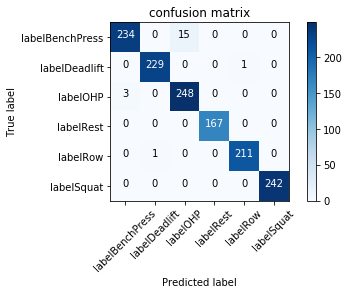

In [15]:
# Performance on the test set
test_cm = eval.confusion_matrix(test_y, class_test_y, class_train_prob_y.columns)
DataViz.plot_confusion_matrix(test_cm, class_train_prob_y.columns, normalize=False)

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

In [16]:
cm = confusion_matrix(test_y, class_test_y, class_train_prob_y.columns)
cr = classification_report(test_y, class_test_y, class_train_prob_y.columns)
accuracy = accuracy_score(test_y, class_test_y)

In [34]:
precision_recall_fscore_support(test_y, class_test_y, average='weighted')

(0.98559031229623306, 0.98519615099925983, 0.98518719060643622, None)

In [24]:
accuracy

0.98519615099925983